In [1]:
# 필요한 라이브러리 import

import os
import urllib.request
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import time
import argparse
import torch
import torch.nn as nn
from copy import deepcopy
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR
from sklearn.model_selection import train_test_split

In [ ]:
# dataset 다운로드

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
file_path = os.path.join(os.getcwd(), filename)
if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=os.getcwd())

In [3]:
# meta data laod
# 클래스 정보

file_path = os.path.join(os.getcwd(), "cifar-100-python")
with open(file_path+"/meta", "rb") as infile:
    data = pickle.load(infile, encoding="bytes")
    classes = data["fine_label_names"]

In [4]:
# train data load

def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

train = unpickle(file_path+"/train")

# train과 validation set 분할
# 분할 비율은 7:3 (유동적으로 조절 가능)
x_train, x_val, y_train, y_val = train_test_split(train[b"data"], train[b"fine_labels"], test_size=0.3)

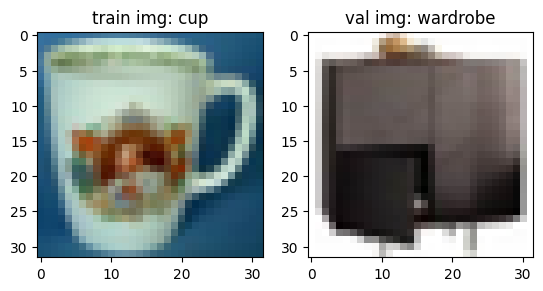

In [5]:
# 이미지와 label 출력 확인

def show_img(index): # 이미지와 label이 제대로 매칭되어 있는지 확인 위해 출력
    train_img, train_target = x_train[index], classes[y_train[index]]
    val_img, val_target = x_val[index], classes[y_val[index]]

    train_img = np.reshape(train_img, (3, 32, 32))
    train_img = train_img.transpose(1, 2, 0)
    val_img = np.reshape(val_img, (3, 32, 32))
    val_img = val_img.transpose(1, 2, 0)

    plt.subplot(1, 2, 1)
    plt.imshow(train_img)
    plt.title("train img: " + train_target)
    plt.subplot(1, 2, 2)
    plt.imshow(val_img)
    plt.title("val img: " + val_target)
    plt.show()

show_img(0)

In [6]:
# 데이터를 tensor 형태로 변환

transform = transforms.Compose([
    transforms.ToTensor(), # 텐서 형태로 변환
    transforms.RandomHorizontalFlip(), # data augmentation 적용
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # data normalization 적용
])

class CustomCIFAR100Dataset():
    def __init__(self, data, labels, transform=None):
        data = np.reshape(data, (-1, 3, 32, 32))
        data = data.transpose((0, 2, 3, 1))
        self.data = data # 데이터
        self.labels = labels # 라벨
        self.transform = transform # 적용할 transform

    def __getitem__(self, idx): # index에 해당되는 data와 label 반환
        img, target = self.data[idx], self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self): # 전체 길이 반환
        return len(self.data)

In [7]:
trainset = CustomCIFAR100Dataset(x_train, y_train, transform) # train dataset 생성
valset = CustomCIFAR100Dataset(x_val, y_val, transform) # validation dataset 생성

partition = {"train": trainset, "val":valset} # 이후 학습 단계(train/val)에 따라 알맞은 dataset 불러오기

In [8]:
# VGG16 구조
# M은 pooling layer, 숫자는 dimension을 의미
# 이후 다른 VGG에도 적용 가능하도록 큰 구조를 리스트 형식으로 생성
vgg16_structure = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]

class VGG16(nn.Module):
    def __init__(self, structure, num_classes = 100, use_bn=True):
        super(VGG16, self).__init__()
        self.layers = self.make_layers(structure, 3, use_bn)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def make_layers(self, structure, in_channels, use_bn):
        layers = []
        for f in structure: # VGG16 구조에 따라 layer 생성
            if f == "M": # max pool
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else: # convolution layer
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=f, kernel_size=3, padding=1))
                layers.append(nn.ReLU())
                in_channels = f

                if use_bn: # batch normalization 적용 여부
                    layers.append(nn.BatchNorm2d(f))
                    layers.append(nn.ReLU()) # 활성화 함수는 batch norm 뒤에 적용
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 모델 생성
net = VGG16(vgg16_structure)

# 모델 정보 출력
print(net)

VGG16(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [9]:
# GPU 사용 가능일 시 모델을 GPU에 올림
# 사용 불가능할 시 그대로 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
def train(net, partition, optimizer, criterion, scheduler, args): # train 단계
    # 미니배치 단위로 train 데이터 loading
    trainloader = torch.utils.data.DataLoader(partition["train"], batch_size=args.train_batch_size, shuffle=True, num_workers=2)
    net.train() # 모델을 train 모드로 setting

    correct = 0 # 초기화
    total = 0 # 초기화
    train_loss = 0.0 # 초기화
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # 매 반복마다 gradient가 누적되지 않도록 하기 위해서

        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device) # 데이터를 cuda에 올림
        labels = labels.to(device) # 데이터를 cuda에 올림
        outputs = net(inputs) # 모델을 통해 나온 예측값

        loss = criterion(outputs, labels) # 예측값과 실제값 사이의 loss 계산 ()
        loss.backward() # back propagation
        optimizer.step() # 가중치 업데이트

        #scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [11]:
def validate(net, partition, criterion, args): # validate 단계
    valloader = torch.utils.data.DataLoader(partition["val"], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    net.eval() # 모델을 평가 모드로 setting

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad(): # 더 이상 학습을 하지 않을 것임 (가중치 업데이트는 train 단계에서 모두 종료)
        for data in valloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
def experiment(partition, args):

    net = VGG16(vgg16_structure)
    net.to(device)

    criterion = nn.CrossEntropyLoss() # loss function으로 CE 사용
    # optimizer로 SGD / RMSprop / Adam 중 하나를 사용
    if args.optim == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, nesterov=True, weight_decay=args.l2)
    elif args.optim == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # scheduler는 사용하지 않게 됨
    scheduler = LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

    for epoch in range(args.epoch): # loop over the dataset multiple times
        ts = time.time() # 시작 시간 측정
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, scheduler, args) # train 단계의 loss와 accuracy 계산
        val_loss, val_acc = validate(net, partition, criterion, args) # validation 단계의 loss와 accuracy 계산
        te = time.time() # 종료 시간 측정

        train_losses.append(train_loss) # 에폭에 따른 loss 값의 변화 저장
        val_losses.append(val_loss) # 에폭에 따른 loss 값의 변화 저장
        train_accs.append(train_acc) # 에폭에 따른 accuracy 값의 변화 저장
        val_accs.append(val_acc) # 에폭에 따른 accuracy 값의 변화 저장

        # 에폭 수에 따른 loss와 accuracy 변화 확인
        print("Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f}sec".format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    # 결과 저장
    result = {}
    result["train_losses"] = train_losses
    result["val_losses"] = val_losses
    result["train_accs"] = train_accs
    result["val_accs"] = val_accs
    result["train_acc"] = train_acc
    result["val_acc"] = val_acc
    return vars(args), result

In [13]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

# 결과 저장
def save_exp_result(setting, result):
    exp_name = setting["exp_name"]
    del setting["epoch"]
    del setting["test_batch_size"]

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6] # 해시 함수 사용 > 중복이 발생하지 않도록
    filename = "./results-{}-{}.json".format(exp_name, hash_key)
    result.update(setting)
    with open(filename, "w") as f:
        json.dump(result, f)

In [44]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp_lr"

args.l2 = 0.007
args.optim = "SGD"
args.lr = 0.009
args.epoch = 30
args.train_batch_size = 256
args.test_batch_size = 512

setting, result = experiment(partition, args)
save_exp_result(setting, result)

Epoch 0, Acc(train/val): 3.18/5.78, Loss(train/val) 4.47/4.26. Took 11.14sec
Epoch 1, Acc(train/val): 6.67/8.57, Loss(train/val) 4.11/3.95. Took 10.84sec
Epoch 2, Acc(train/val): 10.19/12.05, Loss(train/val) 3.83/3.70. Took 10.60sec
Epoch 3, Acc(train/val): 14.02/15.48, Loss(train/val) 3.60/3.53. Took 10.85sec
Epoch 4, Acc(train/val): 17.59/19.59, Loss(train/val) 3.38/3.30. Took 9.89sec
Epoch 5, Acc(train/val): 21.98/24.15, Loss(train/val) 3.15/3.09. Took 11.66sec
Epoch 6, Acc(train/val): 26.54/25.77, Loss(train/val) 2.92/2.97. Took 13.47sec
Epoch 7, Acc(train/val): 30.81/30.79, Loss(train/val) 2.70/2.71. Took 10.94sec
Epoch 8, Acc(train/val): 34.92/33.39, Loss(train/val) 2.50/2.60. Took 13.21sec
Epoch 9, Acc(train/val): 39.16/35.67, Loss(train/val) 2.32/2.52. Took 10.90sec
Epoch 10, Acc(train/val): 42.50/38.01, Loss(train/val) 2.18/2.44. Took 12.30sec
Epoch 11, Acc(train/val): 45.66/38.67, Loss(train/val) 2.05/2.44. Took 13.71sec
Epoch 12, Acc(train/val): 48.96/41.86, Loss(train/val) 

In [47]:
torch.save(net.state_dict(), "weights_vgg16.pth")